### Load dependencies

In [1]:
import os
import shutil
import time
import pickle
import pandas as pd
import matplotlib.pyplot as pyplot
import librosa
import librosa.display
import gc
import numpy as np
import urllib

def download_rec(uri, rec_dir, filename):
    if not os.path.exists(rec_dir+'/'+uri.replace('/','_')):
        try:
            urllib.request.urlretrieve (uri, rec_dir+'/'+filename)
        except Exception as e:
            print(e)
            print('Error downloading '+uri)
        return


### Specify data paths:

1. train_set_dir - Folder where training data will be stored
2. recording_dir - Folder where audio recordings will be stored
3. sound_annotation_file - File storing template matching validation metadata
4. (Optional) sampling_rate - rate to resample training data recordings to
    

In [2]:
train_set_dir = '/home/gabsoni/Documentos/ENTORNOS/exp1/arbimon2-cnn/train_tp/' # Folder where training data will be stored
recording_dir = '/home/gabsoni/Documentos/ENTORNOS/exp1/arbimon2-cnn/recordings/' # Folder holding recordings

sound_annotation_files = ['/home/gabsoni/Documentos/ENTORNOS/exp1/arbimon2-cnn/sound_annotation_files/rois (9)_FIXED.csv']
# File storing ROIs of detected sounds (animal calls) 
#     Required columns:
#          species
#          x1 (start time of sound)
#          x2 (end time of sound)
#          uri (recording file path)

sampling_rate = 48000 # training data recording sample rate


### Run remaining cells to generate training data

In [3]:
if not os.path.exists(recording_dir):
    os.mkdir(recording_dir)
if not os.path.exists(train_set_dir):
    os.mkdir(train_set_dir)

In [4]:
if len(sound_annotation_files)==1:
    rois= pd.read_csv(sound_annotation_files[0])
elif len(sound_annotation_files)==0:
    print('Must provide an annotation file')
elif len(sound_annotation_files)>1:
    rois = pd.read_csv(sound_annotation_files[0])
    for i in sound_annotation_files[1:]:
        tmp = pd.read_csv(sound_annotation_files[i])
        rois = pd.concat([rois,tmp])
rois.head()

,Unnamed: 0,id,recording,site,year,month,species,songtype,x1,x2,y1,y2,validated,uri,datetime,meta,score,site_id
0,0,168157356,MON_20191019_190000.p2.flac,Angachilla,2019,10,Agelasticus thilius,Alternative Song,29.146848,30.580680,1205.859375,7235.15625,(not validated),https://s3.amazonaws.com/arbimon2/project_2770...,1571511660000,NaN,0.100463,22306
1,1,168157390,MON_20191019_220000.p3.flac,Angachilla,2019,10,Agelasticus thilius,Alternative Song,55.275102,56.708934,1205.859375,7235.15625,(not validated),https://s3.amazonaws.com/arbimon2/project_2770...,1571522520000,NaN,0.100524,22306
2,2,168157125,MON_20191019_020000.p1.flac,Angachilla,2019,10,Agelasticus thilius,Alternative Song,0.696599,2.130431,1205.859375,7235.15625,(not validated),https://s3.amazonaws.com/arbimon2/project_2770...,1571450400000,NaN,0.101080,22306
3,3,168157295,MON_20191019_150000.p1.flac,Angachilla,2019,10,Agelasticus thilius,Alternative Song,48.570340,50.004172,1205.859375,7235.15625,(not validated),https://s3.amazonaws.com/arbimon2/project_2770...,1571497200000,NaN,0.101902,22306
4,4,168157275,MON_20191019_030000.p5.flac,Angachilla,2019,10,Agelasticus thilius,Alternative Song,54.056054,55.489887,1205.859375,7235.15625,(not validated),https://s3.amazonaws.com/arbimon2/project_2770...,1571454240000,NaN,0.101987,22306


In [5]:
# For using Arbimon 2 Pattern Matching results - convert uri to full download URL
rois['uri'] = [i[1].uri.split('detections')[0]+
                  'site_'+str(i[1].site_id)+'/'+
                  str(i[1].year)+'/'+
                  str(i[1].month)+'/'+
                  i[1].recording for i in rois.iterrows()]

In [6]:
print('Number of ROIs for each species\n')

for i in list(set(rois.species)):
    print(str(i)+'\t\t'+str(len(rois[rois.species==i])))

Number of ROIs for each species

Agelasticus thilius		32504


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

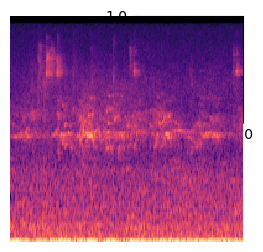

In [7]:
window_length = 2 # sample time-window length in seconds
k = 0
t0 = time.time()
rec_loaded = False

for i in list(set(rois.uri)): # loop over recordings
    
    k = k+1
#     if k%200==0:
    print(k)
        
    tmp = rois[rois.uri==i]
    if 's3.amazonaws' in tmp.iloc[0].uri:
        audio_filename = tmp.iloc[0].uri.replace('/','_').split('arbimon2_')[1]

    for c in range(len(tmp)): # loop over spectrogram ROIs
        #print(c)
        try:

            sound_start, sound_end = [tmp.iloc[c]['x1'], tmp.iloc[c]['x2']]
            species = tmp.iloc[c].species.replace(' ','_')
            
            if not os.path.exists(train_set_dir+'/'+str(species)):
                os.mkdir(train_set_dir+'/'+str(species))

            shft = ((sound_end-sound_start)-window_length)/2
            start_sample = round(sampling_rate*(sound_start+shft))
            start_sample = max(start_sample, 0)
            filename = audio_filename.split('.')[0]+'_'+str(round(start_sample/sampling_rate,2))+'-'+str(round((start_sample/sampling_rate)+window_length,2))+'.png'

            if not os.path.exists(train_set_dir+str(species)+'/'+filename):
                if not rec_loaded:
                    if not os.path.exists(recording_dir+'/'+audio_filename):
                        download_rec(tmp.iloc[0].uri, recording_dir, audio_filename)
                    try:
                        audio_data, sampling_rate = librosa.load(recording_dir+audio_filename, sr=sampling_rate)
                        rec_loaded = True
                    except Exception as e:
                        print(e)
                        continue
                S = librosa.feature.melspectrogram(y = audio_data[int(start_sample): int(start_sample+round(sampling_rate*window_length))], 
                                               sr = sampling_rate,
                                               n_fft=2048, 
                                               hop_length=512, 
                                               win_length=1024)
                dpi=100
                fig = pyplot.figure(num=None, figsize=(300/dpi, 300/dpi), dpi=dpi)
                pyplot.subplot(222)
                ax = pyplot.axes()
                ax.set_axis_off()
                librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
                pyplot.savefig(train_set_dir+str(species.replace(' ','_'))+'/'+filename, bbox_inches='tight', transparent=True, pad_inches=0.0)
                pyplot.close()
                
        except Exception as e:
            #print(e)
            continue
        
    rec_loaded = False    